In [1]:
from tokenizers import TRIETokenizerFast
import torch
from torch import nn
import numpy as np
import tqdm.notebook as tqdm
import time
import bisect
from typing import *
import gc
from dataclasses import dataclass
from flash_attn import flash_attn_func
from flash_attn_triton import flash_attn_func as flash_attn_func_triton
from dataloader import DatasetReader, DatasetIter, SingleDatasetReader, MultiDatasetsReader
from math import ceil
from functools import partial
from matplotlib import pyplot as plt
import bitsandbytes as bnb
from threading import Lock, Thread
import json
import pickle
import os

In [2]:
g_tokenizer = TRIETokenizerFast('llama_vocab_pruned_32k.json')

In [3]:
# Network definition
C_SEQ_LEN = 2048
C_HIDDEN_SIZE = 768
C_NUM_HEADS = 12
C_NUM_LAYERS = 12

C_DEVICE = torch.device('cuda')
C_DTYPE = torch.bfloat16

C_DEBUG = True

In [4]:
if not C_DEBUG:
    g_train_data = MultiDatasetsReader([
        SingleDatasetReader('datasets/minipile_train.bin'),
        SingleDatasetReader('datasets/enwiki_train.bin'),
        SingleDatasetReader('datasets/tinytextbooks_train.bin'),
    ], seed=0)
else:
    g_train_data = MultiDatasetsReader([
        SingleDatasetReader('datasets/debug_data_masked.bin'),
        SingleDatasetReader('datasets/debug_data_masked.bin'),
    ], seed=0)

In [5]:
print('Train samples:', len(g_train_data))
print('Sample length:', len(next(iter(g_train_data))['token_ids']))
print('Train tokens:', len(g_train_data) * len(next(iter(g_train_data))['token_ids']))

Train samples: 2
Sample length: 1024
Train tokens: 2048


In [6]:
print('Sample 1:', g_tokenizer.decode(next(iter(g_train_data))['token_ids']))

Sample 1: <s>Once upon a time there was a little boy named Ben. Ben loved to explore the world around him. He saw many amazing things, like beautiful vases that were on display in a store. One day, Ben was walking through the store when he came across a very special vase. When Ben saw it he was amazed!  
He said, “Wow, that is a really amazing vase! Can I buy it?” 
The shopkeeper smiled and said, “Of course you can. You can take it home and show all your friends how amazing it is!”
So Ben took the vase home and he was so proud of it! He called his friends over and showed them the amazing vase. All his friends thought the vase was beautiful and couldn't believe how lucky Ben was. 
And that's how Ben found an amazing vase in the store!</s><s>Once upon a time, there was a reliable otter named Ollie. He lived in a river with his family. They all loved to play and swim together.
One day, Ollie's mom said, "Ollie, hurry and get some fish for dinner!" Ollie swam fast to catch fish. He saw his

In [63]:
global_config = {
    'enable_torch_attn': False,
    'enable_flash_attn': False,
}


@dataclass
class TransformerConfig:
    vocab_size: int = -1,
    num_layers: int = -1,
    num_heads: int = -1,
    hidden_size: int = -1,
    max_seq_len: int = -1,
    root_model: 'ToyTransformer' = None
    device: torch.device = torch.device('cpu')
    dtype: torch.dtype = torch.float32
    enable_rel_pos: bool = False


def expand_attn_mask(custom_attn_mask: torch.Tensor):
    B, T = custom_attn_mask.shape
    mask = custom_attn_mask.unsqueeze(1).repeat((1, T, 1))
    seq_index_mask = (mask == custom_attn_mask[:, torch.arange(T)].view(B, T, 1))
    return seq_index_mask & (torch.tril(mask) > 0)


# expand attn mask to cu_seqlens for flash attn
def expand_attn_mask_to_seq_lengths(attn_mask: torch.Tensor):
    attn_mask = attn_mask.to('cpu')
    seq_len = attn_mask.shape[0] * attn_mask.shape[1]
    disjoint_point = torch.cat([torch.tensor([[True]] * attn_mask.shape[0]), attn_mask[:, 1:] != attn_mask[:, :-1]], dim=1)
    return torch.cat([torch.nonzero(disjoint_point.view((-1,))), torch.tensor([[seq_len]])]).to(dtype=torch.int32)


# naive RoPE implementation following https://arxiv.org/pdf/2104.09864.pdf
def get_rope_cache_slow(seq_len: int, dim: int, theta: int, device: torch.device, dtype: torch.dtype):
    assert dim % 2 == 0
    freqs = theta ** (-2 * torch.arange(0, dim // 2, 1.) / dim)
    freqs = torch.repeat_interleave(freqs, 2)
    v1 = torch.cos(torch.arange(seq_len, dtype=torch.float).view((seq_len, 1)) * freqs)
    v2 = torch.sin(torch.arange(seq_len, dtype=torch.float).view((seq_len, 1)) * freqs)
    v2 = v2 * torch.tensor([1, -1] * (dim // 2))
    indices = torch.tensor([j for i in range(0, dim, 2) for j in (i + 1, i)])
    return v1.to(device, dtype=dtype), v2.to(device, dtype=dtype), indices.to(device)


def apply_rope_slow(x, rope_cache, positions: Optional[torch.Tensor] = None):
    v1, v2, indices = rope_cache
    seq_len, dim = x.shape[1:]
    if positions is None:
        v1 = v1[:seq_len, :]
        v2 = v2[:seq_len, :]
    else:
        v1 = v1[positions, torch.arange(dim)].view((-1, dim))
        v2 = v2[positions, torch.arange(dim)].view((-1, dim))
    applied_x = x * v1 + (x * v2)[:, :, indices]
    return applied_x


# Optimized RoPE implementation adapted from https://github.com/facebookresearch/llama/blob/main/llama/model.py
def get_rope_cache_fast(seq_len: int, dim: int, theta: int, device: torch.device, dtype: torch.dtype):
    freqs = (1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim)))
    t = torch.arange(seq_len, device=freqs.device)
    freqs = torch.outer(t, freqs).float()
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)
    return freqs_cis.to(device)


def apply_rope_fast(x, rope_cache, positions: Optional[torch.Tensor] = None) -> torch.Tensor:
    x_ = torch.view_as_complex(x.float().reshape(*x.shape[:-1], -1, 2))
    if positions is None and x.shape[1] < rope_cache.shape[0]:
        freqs_cis = rope_cache[:x.shape[1], :]
    elif positions is not None:
        freqs_cis = rope_cache[positions, :]
    else:
        freqs_cis = rope_cache
    freqs_cis = freqs_cis.view([d if i == 1 or i == x_.ndim - 1 else 1 for i, d in enumerate(x_.shape)])

    applied_x = torch.view_as_real(x_ * freqs_cis).flatten(2)
    return applied_x.type_as(x)


class AttentionHead(nn.Module):
    def __init__(self, config: TransformerConfig):
        super().__init__()
        self.config = config
        self.hidden_size = config.hidden_size
        self.dtype = config.dtype
        self.q_proj = nn.Linear(config.hidden_size, config.hidden_size // config.num_heads, dtype=config.dtype)
        self.k_proj = nn.Linear(config.hidden_size, config.hidden_size // config.num_heads, dtype=config.dtype)
        self.v_proj = nn.Linear(config.hidden_size, config.hidden_size // config.num_heads, dtype=config.dtype)

    def forward(self, x: torch.Tensor, attn_mask: Optional[torch.Tensor],
                kv_cache: Optional[List[torch.Tensor]]) -> Tuple[torch.Tensor, List[torch.Tensor]]:
        B, T, C = x.shape

        use_flash_attn = global_config['enable_flash_attn'] and kv_cache is None

        if kv_cache is None and attn_mask is not None:
            apply_mask = expand_attn_mask(attn_mask)
        elif kv_cache is None and attn_mask is None and not use_flash_attn:
            apply_mask = expand_attn_mask(torch.ones(x.shape[:2]))
        elif kv_cache is not None:
            apply_mask = torch.ones((B, T, T), dtype=torch.bool)
        else:
            apply_mask = None

        # fill mask into attn bias
        mask_zero = torch.tensor(0, dtype=self.dtype)
        mask_val = torch.tensor(torch.finfo(self.dtype).min / 2, dtype=self.dtype)
        if apply_mask is not None and not global_config['enable_torch_attn']:
            apply_mask = torch.where(apply_mask, mask_zero, mask_val)  # apply_mask is now attn_bias

        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)

        if self.config.enable_rel_pos:
            positions = torch.tensor([kv_cache[0].shape[1]]).to(q.device) if kv_cache is not None else None
            q = apply_rope_fast(q, self.config.root_model.rope_cache, positions)
            k = apply_rope_fast(k, self.config.root_model.rope_cache, positions)

        if kv_cache is not None:
            k = torch.concat([kv_cache[0], k], dim=1)
            v = torch.concat([kv_cache[1], v], dim=1)

        if use_flash_attn and apply_mask is None:
            q, k, v, = q.unsqueeze(2), k.unsqueeze(2), v.unsqueeze(2)
            attn_result = flash_attn_func(q, k, v, causal=True)
            q, k, v, attn_result = q.squeeze(2), k.squeeze(2), v.squeeze(2), attn_result.squeeze(2)
        elif use_flash_attn and apply_mask is not None:
            q, k, v, = q.unsqueeze(2), k.unsqueeze(2), v.unsqueeze(2)
            attn_result = flash_attn_func_triton(q, k, v, apply_mask.unsqueeze(1).to(q.device), True)
            q, k, v, attn_result = q.squeeze(2), k.squeeze(2), v.squeeze(2), attn_result.squeeze(2)
        elif global_config['enable_torch_attn']:
            with torch.backends.cuda.sdp_kernel(enable_flash=False, enable_math=True, enable_mem_efficient=False):
                attn_result = nn.functional.scaled_dot_product_attention(q, k, v,
                                                                         attn_mask=apply_mask.to(q.device) if apply_mask is not None else None,
                                                                         is_causal=True if apply_mask is None else False)
        else:
            attn_score = (q @ k.permute(0, 2, 1) / (self.hidden_size ** 0.5)) + apply_mask.to(q.device)
            attn_result = torch.softmax(attn_score, dim=2) @ v

        return attn_result, [k, v]


class MultiHeadAttention(nn.Module):
    def __init__(self, config: TransformerConfig):
        super().__init__()
        self.config = config
        self.attn_heads = nn.ModuleList([AttentionHead(config) for _ in range(config.num_heads)])
        self.o_proj = nn.Linear(config.hidden_size, config.hidden_size, dtype=config.dtype)

    def forward(self, x: torch.Tensor, attn_mask: Optional[torch.Tensor],
                kv_cache: Optional[List[torch.Tensor]]) -> Tuple[torch.Tensor, List[List[torch.Tensor]]]:
        head_outputs = [head(x, attn_mask, kv_cache[idx] if kv_cache is not None else None) for idx, head in
                        enumerate(self.attn_heads)]
        return self.o_proj(torch.concat([o[0] for o in head_outputs], dim=2)), [o[1] for o in head_outputs]


class DecoderLayer(nn.Module):
    def __init__(self, config: TransformerConfig):
        super().__init__()
        self.config = config
        self.mha = MultiHeadAttention(config)
        self.up_proj = nn.Linear(config.hidden_size, config.hidden_size * 4, dtype=config.dtype)
        self.down_proj = nn.Linear(config.hidden_size * 4, config.hidden_size, dtype=config.dtype)
        self.ln_mha = nn.LayerNorm(config.hidden_size, dtype=config.dtype)
        self.ln_ffn = nn.LayerNorm(config.hidden_size, dtype=config.dtype)
        self.act = nn.GELU()

    def forward(self, x: torch.Tensor, attn_mask: Optional[torch.Tensor],
                kv_cache: Optional[List[torch.Tensor]]) -> Tuple[torch.Tensor, List[List[torch.Tensor]]]:
        mha_output, new_kv_cache = self.mha(self.ln_mha(x), attn_mask, kv_cache)
        mha_output = x + mha_output
        ffn_output = self.down_proj(self.act(self.up_proj(self.ln_ffn(mha_output))))
        return mha_output + ffn_output, new_kv_cache


class ToyTransformer(nn.Module):
    def __init__(self, vocab_size: int, num_layers: int, num_heads: int, hidden_size: int, max_seq_len: int,
                 device: torch.device = torch.device('cpu'), dtype: torch.dtype = torch.float32,
                 enable_rel_pos: bool = False):
        super().__init__()
        self.config = TransformerConfig(vocab_size, num_layers, num_heads, hidden_size, max_seq_len, self, device,
                                        dtype, enable_rel_pos)

        self.sem_embed = nn.Embedding(vocab_size, hidden_size, dtype=dtype)

        if not self.config.enable_rel_pos:
            self.pos_embed = nn.Embedding(max_seq_len, hidden_size, dtype=dtype)
        else:
            # self.rope_cache = get_rope_cache(max_seq_len, hidden_size // num_heads, 10000, device, dtype)
            self.rope_cache = get_rope_cache_fast(max_seq_len, hidden_size // num_heads, 10000, device, dtype)

        self.decoder_layers = nn.ModuleList([DecoderLayer(self.config) for _ in range(num_layers)])
        self.lm_head = nn.Linear(hidden_size, vocab_size, dtype=dtype)
        self.to(device)

    def forward(self, seq: torch.Tensor,
                position_ids: Optional[torch.Tensor] = None,
                attn_mask: Optional[torch.Tensor] = None,
                kv_cache: Optional[List[torch.Tensor]] = None) -> Tuple[torch.Tensor, List[List[List[torch.Tensor]]]]:

        if self.config.enable_rel_pos:
            hidden = self.sem_embed(seq)
        elif position_ids is not None:
            hidden = self.sem_embed(seq) + self.pos_embed(position_ids)
        else:
            hidden = self.sem_embed(seq) + self.pos_embed(torch.arange(0, seq.shape[1], 1).to(self.device))

        new_kv_cache = []
        for idx, decoder in enumerate(self.decoder_layers):
            hidden, layer_kv_cache = decoder(hidden, attn_mask, kv_cache[idx] if kv_cache is not None else None)
            new_kv_cache.append(layer_kv_cache)

        logits = self.lm_head(hidden)

        return logits, new_kv_cache

    @property
    def device(self):
        return next(self.parameters()).device

In [64]:
if C_DEBUG:
    g_model = ToyTransformer(g_tokenizer.get_vocab_size(), 2, 2, 256, 1024, C_DEVICE, C_DTYPE, enable_rel_pos=True)
else:
    g_model = ToyTransformer(g_tokenizer.get_vocab_size(), C_NUM_LAYERS, C_NUM_HEADS, C_HIDDEN_SIZE, C_SEQ_LEN, C_DEVICE, C_DTYPE, enable_rel_pos=True)

In [65]:
print('Total parameters:', sum([t.numel() for t in g_model.parameters()]))
print(g_model)

Total parameters: 18389504
ToyTransformer(
  (sem_embed): Embedding(32768, 256)
  (decoder_layers): ModuleList(
    (0-1): 2 x DecoderLayer(
      (mha): MultiHeadAttention(
        (attn_heads): ModuleList(
          (0-1): 2 x AttentionHead(
            (q_proj): Linear(in_features=256, out_features=128, bias=True)
            (k_proj): Linear(in_features=256, out_features=128, bias=True)
            (v_proj): Linear(in_features=256, out_features=128, bias=True)
          )
        )
        (o_proj): Linear(in_features=256, out_features=256, bias=True)
      )
      (up_proj): Linear(in_features=256, out_features=1024, bias=True)
      (down_proj): Linear(in_features=1024, out_features=256, bias=True)
      (ln_mha): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (ln_ffn): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (act): GELU(approximate='none')
    )
  )
  (lm_head): Linear(in_features=256, out_features=32768, bias=True)
)


In [66]:
gc.collect()
torch.cuda.empty_cache()

In [67]:
def dataset_collate(dataset_iter: DatasetIter, batch_size: int,
                    transform: Optional[Callable[[Dict[str, List[np.ndarray]]], Dict[str, torch.Tensor]]] = None,
                    drop_last: bool = False):
    cur_batch, cur_batch_size = {}, 0
    for entry in dataset_iter:
        for k, v in entry.items():
            cur_batch.setdefault(k, [])
            cur_batch[k].append(v)
        cur_batch_size += 1
        if cur_batch_size == batch_size:
            yield {k: torch.tensor(np.stack(v)) for k, v in cur_batch.items()} if transform is None else transform(cur_batch)
            cur_batch = {}
            cur_batch_size = 0
    if not drop_last and len(cur_batch) > 0:
        yield {k: torch.tensor(np.stack(v)) for k, v in cur_batch.items()} if transform is None else transform(cur_batch)

In [68]:
@dataclass
class TrainArguments:
    num_epochs: int
    batch_size: int
    gradient_accumulation_steps: int

    optimizer: Type[torch.optim.Optimizer]
    optimizer_args: Optional[Dict[str, Any]]

    start_lr: float
    max_lr: float
    end_lr: float
    warmup_ratio: float

    gradient_clip_norm: Optional[float]

    train_data: DatasetReader
    ignore_attn_mask: bool
    ignore_loss_mask: bool

    # eval_data: Optional[DatasetReader]
    # eval_steps: int
    # 
    # eval_generate_prompt: Optional[str]
    # eval_generate_steps: int

    save_steps: int
    save_on_interrupt: bool


# type cast for handling int16/uint16 columns
def train_transform(batch: Dict[str, List[np.ndarray]]):
    return {k: torch.tensor(np.stack(v, dtype=np.int32 if v[0].dtype in [np.int16, np.uint16] else v[0].dtype)) for k, v in batch.items()}


def save_checkpoint(path: str, model: nn.Module,
                    optimizer: torch.optim.Optimizer, lr_scheduler: torch.optim.lr_scheduler.LRScheduler,
                    train_args: TrainArguments,
                    dataset: DatasetReader, dataset_iter: DatasetIter, train_logs: List, misc: Dict):
    if not os.path.exists(path):
        os.mkdir(path)
    torch.save(model.state_dict(), path + '/model.pt')
    torch.save(optimizer.state_dict(), path + '/optimizer.pt')
    torch.save(lr_scheduler.state_dict(), path + '/lr_scheduler.pt')
    torch.save(torch.get_rng_state(), path + '/rng_state.pt')
    torch.save(train_args, path + '/train_args.pt')
    dataset.save_iterator(dataset_iter, path + '/dataset_iter.pt')
    torch.save(train_logs, path + '/train_logs.pt')
    torch.save(misc, path + '/misc.pt')


def load_checkpoint(path: str, model: nn.Module,
                    optimizer: torch.optim.Optimizer, lr_scheduler: torch.optim.lr_scheduler.LRScheduler,
                    train_args: TrainArguments,
                    dataset: DatasetReader, dataset_iter: DatasetIter, train_logs: List, misc: Dict):
    model.load_state_dict(torch.load(path + '/model.pt'))
    optimizer.load_state_dict(torch.load(path + '/optimizer.pt'))
    lr_scheduler.load_state_dict(torch.load(path + '/lr_scheduler.pt'))
    torch.set_rng_state(torch.load(path + '/rng_state.pt'))
    # assert torch.load(path + '/train_args.pt') == train_args
    dataset_iter.set_state(dataset.load_iterator(path + '/dataset_iter.pt').get_state())
    train_logs.clear()
    train_logs += torch.load(path + '/train_logs.pt')
    misc.update(torch.load(path + '/misc.pt'))


def train_model(model: nn.Module, train_args: TrainArguments,
                resume_from: Optional[str] = None,
                show_progress: bool = True,
                output_dir: str = 'checkpoints', interrupt_lock: Optional[Lock] = None):
    interrupted = False
    train_logs = []
    misc = {'epochs': 0, 'steps': 0, 'last_batch_idx': -1}

    total_samples = len(train_args.train_data)
    epoch_steps = ceil(total_samples / train_args.batch_size)
    assert epoch_steps >= train_args.gradient_accumulation_steps, \
        f'per-epoch steps {epoch_steps} is less than gradient accumulation steps {train_args.gradient_accumulation_steps}'

    schedule_steps = ceil(total_samples / train_args.batch_size / train_args.gradient_accumulation_steps)
    total_steps = schedule_steps * train_args.num_epochs

    optimizer = train_args.optimizer(model.parameters(), **(train_args.optimizer_args if train_args.optimizer_args is not None else {}))
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=train_args.max_lr, div_factor=train_args.max_lr / train_args.start_lr,
                                                    total_steps=total_steps,
                                                    final_div_factor=train_args.start_lr / train_args.end_lr, pct_start=train_args.warmup_ratio)

    dataset_iter = iter(train_args.train_data)
    if resume_from is not None:
        load_checkpoint(resume_from, model, optimizer, scheduler, train_args, train_args.train_data, dataset_iter, train_logs, misc)

    bar = tqdm.tqdm(total=total_steps, smoothing=1.0, disable=not show_progress)
    bar.update(misc['steps'])

    model.train()

    for epoch_num in range(train_args.num_epochs):
        if epoch_num < misc['epochs']:
            continue
        optimizer.zero_grad()
        for batch_idx, batch in enumerate(dataset_collate(dataset_iter, train_args.batch_size, train_transform), start=misc['last_batch_idx'] + 1):
            step_start_time = time.time()

            tokens = batch['token_ids'].to(model.device)
            inputs = tokens[:, :-1]
            labels = tokens[:, 1:]

            positions = batch['position_ids'][:, :-1].to(model.device) if 'position_ids' in batch else None
            attn_mask = batch['attn_mask'][:, :-1].to(model.device) if 'attn_mask' in batch and not train_args.ignore_attn_mask else None
            loss_mask = batch['loss_mask'][:, :-1].to(model.device) if 'loss_mask' in batch and not train_args.ignore_loss_mask else None

            logits, kv_state = model.forward(inputs, position_ids=positions, attn_mask=attn_mask)

            probs = torch.softmax(logits, dim=2).view(-1, logits.shape[-1])

            loss = (-torch.log(probs[torch.arange(probs.shape[0]), labels.reshape(-1)]))
            if loss_mask is not None:
                loss = (loss * loss_mask.reshape(-1)).mean() / train_args.gradient_accumulation_steps
            else:
                loss = loss.mean() / train_args.gradient_accumulation_steps

            # brutally clear nan, give up the whole batch
            if torch.isnan(loss):
                print(f'encountered nan loss at epoch {epoch_num + 1}, batch {batch_idx}')
                # optimizer.zero_grad()
            else:
                loss.backward()

            if (batch_idx + 1) % train_args.gradient_accumulation_steps == 0 or (batch_idx + 1) == epoch_steps:
                if train_args.gradient_clip_norm is not None:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), train_args.gradient_clip_norm)
                optimizer.step()
                optimizer.zero_grad()

                step_time_cost = time.time() - step_start_time
                throughput = round(probs.shape[0] / step_time_cost / 1000, 2)

                step_stat = {'Loss': f'{loss.item() * train_args.gradient_accumulation_steps:.3f}',
                             'LR': f'{scheduler.get_last_lr()[0]:.2e}',
                             'Throughput': f'{throughput} kt/s'}

                if show_progress:
                    bar.set_description(f'Epoch {epoch_num + 1}')
                    bar.set_postfix(step_stat)
                else:
                    print(', '.join(f'{s[0]}:{s[1]}' for s in step_stat.items()))

                scheduler.step()
                bar.update(1)
                train_logs.append((epoch_num, batch_idx, step_stat))

                misc['steps'] += 1
                misc['last_batch_idx'] = batch_idx
                if train_args.save_steps > 0 and (misc['steps'] % train_args.save_steps) == 0:
                    save_checkpoint(output_dir + f'/checkpoint-{misc["steps"]}',
                                    model, optimizer, scheduler, train_args, train_args.train_data, dataset_iter, train_logs, misc)
                if interrupt_lock is not None and not interrupt_lock.locked():
                    if train_args.save_on_interrupt:
                        save_checkpoint(output_dir + f'/checkpoint-{misc["steps"]}',
                                        model, optimizer, scheduler, train_args, train_args.train_data, dataset_iter, train_logs, misc)
                    interrupted = True
                    break
        if interrupted:
            break
        misc['epochs'] += 1
        misc['last_batch_idx'] = -1
        dataset_iter = iter(train_args.train_data)
    bar.close()

    if not interrupted:
        save_checkpoint(output_dir + f'/checkpoint-done',
                        model, optimizer, scheduler, train_args, train_args.train_data, dataset_iter, train_logs, misc)

    return train_logs


def train_model_interruptable(model: nn.Module, train_args: TrainArguments,
                              resume_from: Optional[str] = None,
                              show_progress: bool = True,
                              output_dir: str = 'checkpoints'):
    return_value, run_finish = None, False

    def return_value_wrapper(func, *args, **kwargs):
        nonlocal return_value, run_finish
        return_value = func(*args, **kwargs)
        run_finish = True

    interrupt_lock = Lock()
    interrupt_lock.acquire()
    thread = Thread(target=return_value_wrapper, args=(train_model, model, train_args),
                    kwargs={'resume_from': resume_from, 'show_progress': show_progress, 'output_dir': output_dir, 'interrupt_lock': interrupt_lock})
    thread.start()
    while not run_finish:
        try:
            time.sleep(0.1)
        except KeyboardInterrupt as _:
            interrupt_lock.release()
            break
    thread.join()

    return return_value

In [70]:
if C_DEBUG:
    g_train_args = TrainArguments(
        num_epochs=1000, batch_size=8, gradient_accumulation_steps=1,
        optimizer=torch.optim.AdamW, optimizer_args=None,
        start_lr=1e-5, max_lr=1e-3, end_lr=1e-6, warmup_ratio=0.1,
        gradient_clip_norm=1.0,
        train_data=g_train_data, ignore_attn_mask=False, ignore_loss_mask=False,
        # eval_data=None, eval_steps=-1,
        # eval_generate_prompt=None, eval_generate_steps=-1,
        save_steps=-1,
        save_on_interrupt=False,
    )
else:
    g_train_args = TrainArguments(
        num_epochs=2, batch_size=12, gradient_accumulation_steps=8,
        optimizer=torch.optim.AdamW, optimizer_args=None,
        start_lr=5e-5, max_lr=1e-3, end_lr=1e-4, warmup_ratio=0.1,
        gradient_clip_norm=0.7,
        train_data=g_train_data, ignore_attn_mask=True, ignore_loss_mask=True,
        # eval_data=None, eval_steps=-1,
        # eval_generate_prompt=None, eval_generate_steps=-1,
        save_steps=1000,
        save_on_interrupt=True
    )

In [71]:
if C_DEBUG:
    global_config['enable_flash_attn'] = True
    global_config['enable_torch_attn'] = False
    g_train_logs = train_model_interruptable(g_model, g_train_args, resume_from=None,
                                             show_progress=True, output_dir='checkpoints/debug_output')
else:
    global_config['enable_flash_attn'] = True
    global_config['enable_torch_attn'] = False
    g_train_logs = train_model_interruptable(g_model, g_train_args, resume_from='checkpoints/train-round1/checkpoint-2367',
                                             show_progress=True, output_dir='checkpoints/train-round1')

  0%|          | 0/1000 [00:00<?, ?it/s]

In [72]:
def plot_train_logs(train_logs):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].plot([float(l[2]['Loss']) for l in train_logs])
    axes[1].plot([float(l[2]['LR']) for l in train_logs])
    axes[2].plot([float(l[2]['Throughput'][:-5]) for l in train_logs])
    axes[0].set_title('Loss')
    axes[1].set_title('Learning Rate')
    axes[2].set_title('Throughput (kt/s)')

    for ax in axes:
        ax.autoscale()

    plt.tight_layout()
    plt.show()

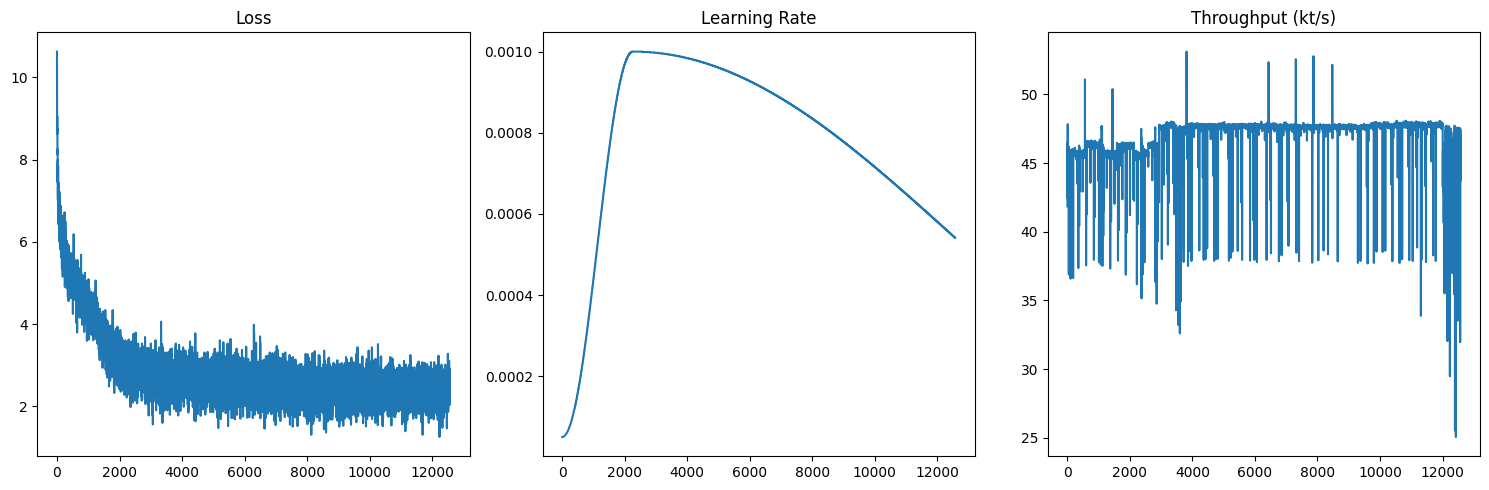

In [73]:
checkpoint_list = [
    'checkpoints/train-round1/checkpoint-12571/train_logs.pt',
]
checkpoint_list = [torch.load(c) for c in checkpoint_list]

for c in checkpoint_list:
    plot_train_logs(c)

In [74]:
def generate(model, tokenizer, prompt, temperature, top_p, rep_penalty,
             max_new_tokens=20, total_tokens=None,
             end_tokens=None,
             enable_kv_cache=True):
    model.eval()

    feed_tokens = tokenizer.encode(prompt)
    all_tokens = feed_tokens.copy()
    if total_tokens is not None:
        max_new_tokens = max(0, total_tokens - len(feed_tokens))

    with torch.no_grad():
        kv_cache = None
        for _ in range(max_new_tokens):
            position_ids = None if kv_cache is None else torch.tensor([[len(all_tokens) - 1]]).to(model.device)
            logits, kv_cache = model.forward(
                torch.tensor([feed_tokens if enable_kv_cache else all_tokens]).to(model.device),
                position_ids=position_ids,
                kv_cache=kv_cache)
            logits = logits[0][-1].cpu()
            if not enable_kv_cache:
                kv_cache = None

            # apply repetition penalty
            logits_rep = torch.gather(logits, 0, torch.tensor(all_tokens))
            logits_rep = torch.where(logits_rep < 0, logits_rep * rep_penalty, logits_rep / rep_penalty)
            logits.scatter_(0, torch.tensor(all_tokens), logits_rep)

            # apply temperature
            logits /= max(temperature, 1e-6)

            probs = torch.softmax(logits, dim=0)

            # apply top-p
            ordered_probs, ordered_indices = torch.sort(probs, descending=True)
            cum_probs = torch.cumsum(ordered_probs, dim=0).tolist()
            top_p_index = bisect.bisect_right(cum_probs, top_p) + 1
            ordered_probs, ordered_indices = ordered_probs[:top_p_index], ordered_indices[:top_p_index]
            sampled_index = ordered_indices[torch.multinomial(ordered_probs, num_samples=1).item()].item()

            all_tokens.append(sampled_index)
            feed_tokens = [sampled_index]

            if end_tokens is not None and sampled_index in end_tokens:
                break

    return tokenizer.decode(all_tokens)

In [75]:
for t in g_tokenizer.decode(next(iter(g_train_data))['token_ids'].tolist()).split('</s>')[:3]:
    print(t)

<s>Once upon a time there was a little boy named Ben. Ben loved to explore the world around him. He saw many amazing things, like beautiful vases that were on display in a store. One day, Ben was walking through the store when he came across a very special vase. When Ben saw it he was amazed!  
He said, “Wow, that is a really amazing vase! Can I buy it?” 
The shopkeeper smiled and said, “Of course you can. You can take it home and show all your friends how amazing it is!”
So Ben took the vase home and he was so proud of it! He called his friends over and showed them the amazing vase. All his friends thought the vase was beautiful and couldn't believe how lucky Ben was. 
And that's how Ben found an amazing vase in the store!
<s>Once upon a time, there was a reliable otter named Ollie. He lived in a river with his family. They all loved to play and swim together.
One day, Ollie's mom said, "Ollie, hurry and get some fish for dinner!" Ollie swam fast to catch fish. He saw his friend, the 

In [79]:
a = time.time()
global_config['enable_flash_attn'] = True
global_config['enable_torch_attn'] = False
result = generate(g_model, g_tokenizer, '<s>Once upon a time there was a little boy named Ben',
                  temperature=1.0, top_p=0.01, rep_penalty=1.0,
                  total_tokens=512,
                  end_tokens=g_tokenizer.encode('<reserved_0>'),
                  enable_kv_cache=True)
print(result)
print(f'{time.time() - a:.3f} sec(s)')

<s>Once upon a time there was a little boy named Ben. Ben loved to explore the world around him. He saw many amazing things, like beautiful vases that were on display in a store. One day, Ben was walking through the store when he came across a very special vase. When Ben saw it he was amazed!  
He said, “Wow, that is a really amazing vase! Can I buy it?” 
The shopkeeper smiled and said, “Of course you can. You can take it home and show all your friends how amazing it is!”
So Ben took the vase home and he was so proud of it! He called his friends over and showed them the amazing vase. All his friends thought the vase was beautiful and couldn't believe how lucky Ben was. 
And that's how Ben found an amazing vase in the store!</s><s>!</s><s>!</s><s>!</s><s>!</s><s>!</s><s>!</s><s>!” 
And that special vase in the vase in his friends over and couldn't believe how lucky Ben took the store!</s><s>!” 
One day, “Of course you can be found an amazing vase in the vase home and couldn't believe ho